In [344]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [345]:
# Reading Data 
filepath = 'data\original_data.csv'

og_data = pd.read_csv(filepath)
#og_data.head()

Text(0.5, 1.0, 'Pass Fail Distribution of Dataset')

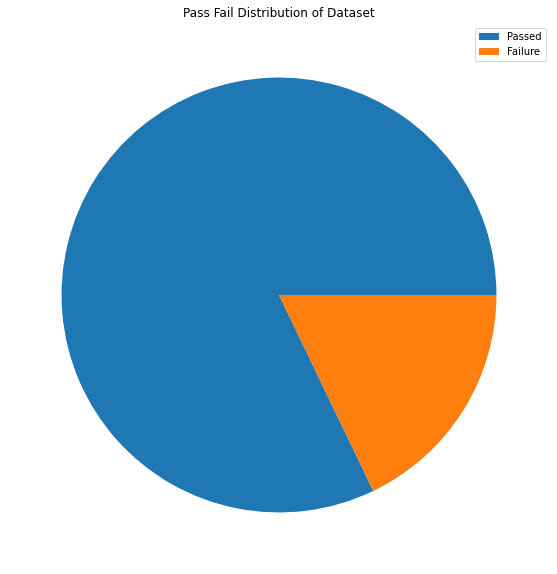

In [346]:
# Performing Initial EDA
og_data.dtypes.value_counts()
og_data.dtypes

fig = plt.figure(figsize=(10,10))
ax = plt.axes()

ax.pie(x=og_data['Pass'].value_counts())
labels = ['Passed','Failure']
ax.legend(labels)
ax.set_title('Pass Fail Distribution of Dataset')

Text(0.5, 1.0, 'Number of Previously Failed Classes vs Total Number of Fails')

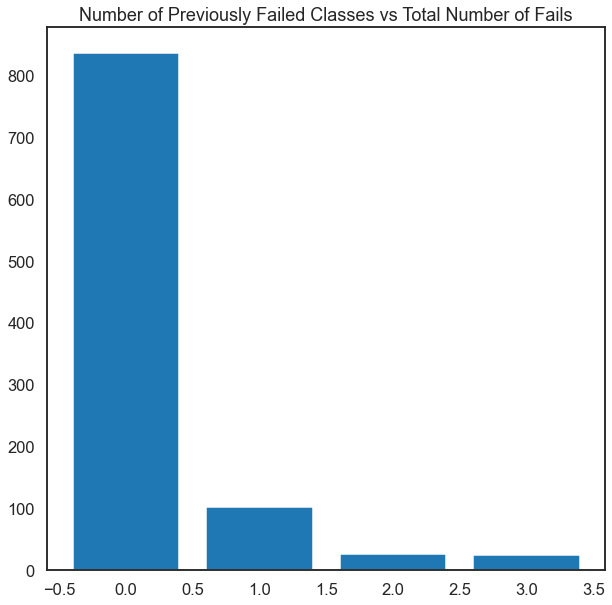

In [431]:
three_fails = pd.DataFrame(og_data[og_data['failures'] == 3]['Pass']).shape[0]
two_fails = pd.DataFrame(og_data[og_data['failures'] == 2]['Pass']).shape[0]
one_fails = pd.DataFrame(og_data[og_data['failures'] == 1]['Pass']).shape[0]
zero_fails = pd.DataFrame(og_data[og_data['failures'] == 0]['Pass']).shape[0]
y_axis = [zero_fails, one_fails, two_fails, three_fails]
x_axis = [0,1,2,3]

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.bar(x=x_axis,height=y_axis)
ax.set_title('Number of Previously Failed Classes vs Total Number of Fails')

<AxesSubplot:>

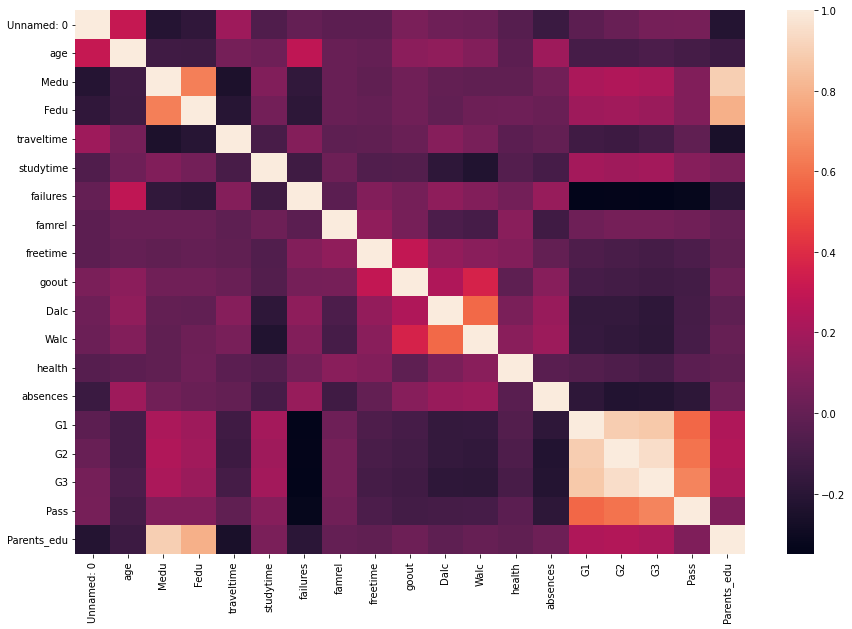

In [348]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(og_data.corr())

In [349]:
# It can be observed from the heatmap that "Pass" is positively correlated with each of the test scores("G1","G2","G3"); this makes intuitive sense. Its also observed that "Pass" is negatively correlated with "absences", "Walc(weekend alcohol consumption", "Dalc(weekday alcohol consumption", "freetime", "failures", and "age". All of these correlations make intuitive sense except the "age" correlation thus we will investigate that correlation further. 

Total Number of Students Age 22:  2
Total Number of Students Age 22 and Failed:  2


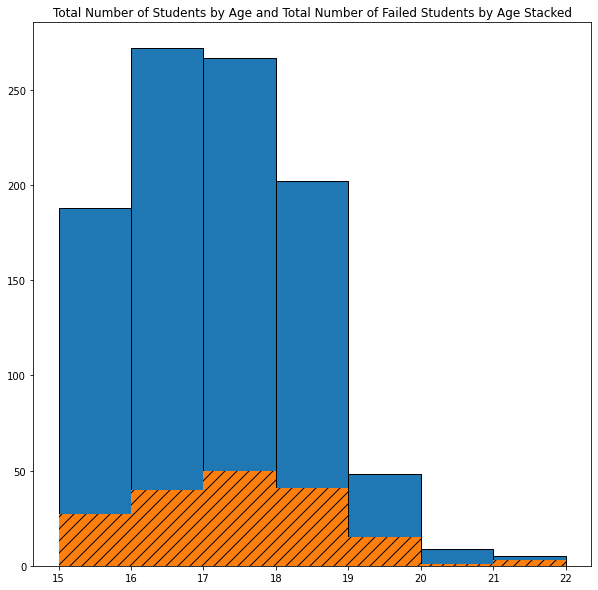

In [350]:
# Investigation into the correlation between age and pass
mybins = [15,16,17,18,19,20,21,22]
list = og_data['age']
list2 = og_data[og_data['Pass'] == False]['age']
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
_, bins, _ = ax.hist(list, bins=mybins, edgecolor='black', align='mid')
ax.hist(list2, bins=bins, hatch='//')
ax.set_title('Total Number of Students by Age and Total Number of Failed Students by Age Stacked')
print('Total Number of Students Age 22: ', og_data[(og_data['age'] == 22)]['age'].shape[0])
print('Total Number of Students Age 22 and Failed: ', og_data[(og_data['age'] == 22) & (og_data['Pass'] == False)].shape[0])

In [351]:
# By observation of the plot it can be seen that due to the low number of older student samples we have an unbalanced class. This is leading to a synthetic negative correlation between age and student pass rate thus the 'age' feature column will not be used in this analysis.
# To begin with I will use a simple model using only 'Pass', 'absences', 'Walc', 'Dalc', 'goout', 'freetime', 'failures', 'G1', 'G2', and 'G3'.
# Quickly I have found that a decision tree model was able to create a one node model with G3, if a student passed if and only if their score met a certain threshould. Thus I will not be using 'G1' 'G2', and 'G3" as feature columns.

In [352]:
# Feature selection and cleaning
featureCols1 = ['absences', 'Fedu', 'Medu', 'Walc', 'Dalc', 'goout', 'freetime', 'failures']
labelCol1 = ['Pass']
x_data1 = og_data[featureCols1]
y_data1 = og_data[labelCol1]

y_data1 = y_data1.replace(to_replace=[True, False], value=[1,0])

In [369]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data1, y_data1, test_size=0.2, stratify=y_data1, random_state = 12)

In [370]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [432]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model):
    coef_dict = {}
    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X_test.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

In [394]:
# Standard logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

train_test_full_error_lr = pd.concat([measure_error(y_train, y_train_pred_lr, 'train'),
                              measure_error(y_test, y_test_pred_lr, 'test')],
                              axis=1)

train_test_full_error_lr

,train,test
accuracy,0.830808,0.844221
precision,0.840580,0.851064
recall,0.980031,0.981595
f1,0.904965,0.911681


In [433]:
coef_dict = get_feature_coefs(lr)
coef_dict

{'failures': -0.8140135265946192,
 'goout': -0.14418417240122203,
 'absences': -0.13834706620930612,
 'freetime': -0.05733659991086697,
 'Walc': -0.05025462388591416,
 'Dalc': 0.05202231604277808,
 'Fedu': 0.10783323979031208,
 'Medu': 0.17839919771991306}

In [372]:
# Decision Tree Model
### BEGIN SOLUTION
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)


In [373]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)
train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_dt, 'train'),
                                 measure_error(y_test, y_test_pred_dt, 'test')],
                                axis=1)
train_test_gr_error

,train,test
accuracy,0.964646,0.703518
precision,0.996810,0.842105
recall,0.960061,0.785276
f1,0.978091,0.812698


In [374]:
dt.tree_.node_count, dt.tree_.max_depth

(477, 14)

In [375]:

### BEGIN SOLUTION
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [376]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)
train_test_gr_error


,train,test
accuracy,0.837121,0.839196
precision,0.843421,0.846561
recall,0.984639,0.981595
f1,0.908575,0.909091


In [377]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(15, 3)

In [378]:
from sklearn.ensemble import RandomForestClassifier

# Define a black-box random forest model
black_box_model = RandomForestClassifier(random_state = 123, max_depth=25, 
                             max_features=10, n_estimators=100, 
                             bootstrap=True)
# Train the model
black_box_model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=25, max_features=10, random_state=123)

In [379]:
y_train_blackbox = black_box_model.predict(X_train)
y_test_blackbox = black_box_model.predict(X_test)

train_test_Blackbox_error = pd.concat([measure_error(y_train, y_train_blackbox, 'train'),
                                 measure_error(y_test, y_test_blackbox, 'test')],
                                axis=1)
train_test_gr_error


,train,test
accuracy,0.837121,0.839196
precision,0.843421,0.846561
recall,0.984639,0.981595
f1,0.908575,0.909091


In [380]:
metrics.roc_auc_score(y_test, y_test_blackbox)

0.6129004771642809

Text(0.5, 1.0, 'Random Forest Truth Table')

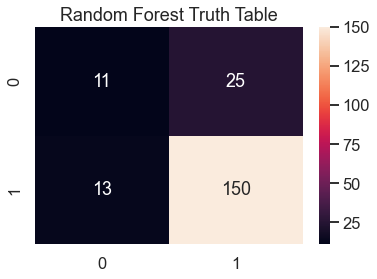

In [437]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_test_blackbox)
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_title('Random Forest Truth Table')

In [387]:
from sklearn.inspection import permutation_importance, plot_partial_dependence

feature_importances = permutation_importance(estimator=black_box_model, X = X_train, y = y_train, n_repeats=10,
                                random_state=123, n_jobs=2)

In [388]:
def visualize_feature_importance(importance_array):
    # Sort the array based on mean value
    sorted_idx = importance_array.importances_mean.argsort()
    # Visualize the feature importances using boxplot
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(10)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])
    ax.set_title("Permutation Importances (train set)")
    plt.show()

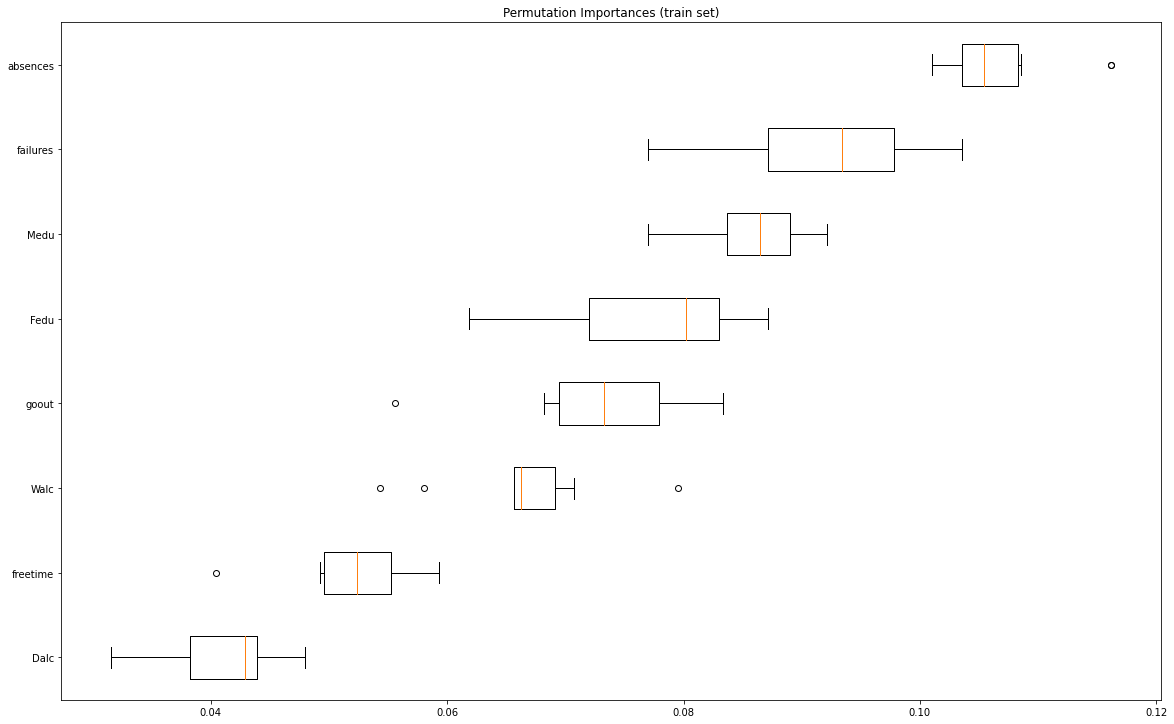

In [389]:
visualize_feature_importance(feature_importances)

In [395]:
# normalize X_test
min_max_scaler = StandardScaler()
X_test_minmax = min_max_scaler.fit_transform(X_test)

In [396]:
lm_surrogate = LogisticRegression(max_iter=1000, 
                                  random_state=123, penalty='l1', solver='liblinear')
lm_surrogate.fit(X_test_minmax, y_test_blackbox)

LogisticRegression(max_iter=1000, penalty='l1', random_state=123,
                   solver='liblinear')

In [397]:
y_surrogate = lm_surrogate.predict(X_test_minmax)

In [401]:
surrogate_metrics = measure_error(y_test_blackbox, y_surrogate, 'test')
surrogate_metrics

accuracy     0.899497
precision    0.910053
recall       0.982857
f1           0.945055
Name: test, dtype: float64

In [403]:
coef_dict = get_feature_coefs(lm_surrogate)
coef_dict

{'failures': -0.9644815121446886,
 'absences': -0.2720085045288319,
 'freetime': -0.09719708549442017,
 'Walc': 0.2002588730112405}